In [46]:
from sklearn.model_selection import train_test_split
import pandas as pd
from collections import Counter
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize
import string
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
import nltk
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline
import re
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV
from sklearn.naive_bayes import MultinomialNB
from wordcloud import WordCloud
from sklearn.dummy import DummyClassifier
import numpy as np

In [47]:
stop_words = set(nltk.corpus.stopwords.words('english'))

In [48]:
import warnings
warnings.filterwarnings('ignore')

In [81]:
def build_grid(clfs_hyperparmans_grid={}, dim_reduction =True):
    # създава решетка от хиперпараметри за класификатор
    grid = {
        'vectorizer__ngram_range': [(1,1), (1,2)],
        'vectorizer__max_features': [1500,1000,900,None],
        'vectorizer__min_df': [1,2],
        "feature_selection__k": [800,900,1000],
    }
    if dim_reduction:
         grid["dim_reduction__n_components"] = [100 ,200,300,400]
        
    for item in clfs_hyperparmans_grid.items():
        grid[item[0]] = item[1]
    return grid
    

In [69]:
def clf_scores(model,y_true,preds,class_names):
    # По даден модел изчислява оценките Accuracy,Precision,Recall, F1
    model_name = str(model)    
    model_name= model_name[:model_name.index('(')]

    accuracy = metrics.accuracy_score(y_true, preds)
    precision = metrics.precision_score(y_true, preds,average='macro')
    recall = metrics.recall_score(y_true, preds,average='macro')
    f1 = metrics.f1_score(y_true, preds,average='macro')
    print(f"\t\t\t\t{model_name}")
    print(metrics.classification_report(y_true,preds,target_names=class_names))
    return [model_name,np.round(accuracy,2),np.round(precision,2),np.round(recall,2), np.round(f1,2)]

In [49]:
def plot_word_count(column_name, title):
    # чертае броя на думите в всеки клас
    plt.figure(figsize=(8,5))
    plt.title(title)
   
    df.groupby('target')[column_name].sum().plot.bar()
    plt.ylabel('Брой думи')
    plt.xlabel('Класове')

In [107]:
final_models = {
    "names": [],
    "Accuracy": [],
    "Macro-Precision": [],
    "Macro-Recall": [],
    "Macro-F1": []
}

def add_to_dict(c1):
    final_models['names'].append(c1[0])
    final_models['Accuracy'].append(c1[1])
    final_models['Macro-Precision'].append(c1[2])
    final_models['Macro-Recall'].append(c1[2])
    final_models['Macro-F1'].append(c1[3])


In [68]:
def build_pipeline(model,feature_select=True):
    p = [
        ('vectorizer', TfidfVectorizer(tokenizer=CustomTokenizer())),
        ('feature_selection', SelectKBest(score_func=chi2,k=900)),
        ('dim_reduction', TruncatedSVD()),
        ('classifier',model)
    ]
    # TruncatedSVD не се изпорзва за MultinomialNB
    if "MultinomialNB" in str(model):
        p = p[:2] + p[3:] 
    if not feature_select:
        p = p[:1] + p[2:]
    pipeline = Pipeline(p)

        
    return pipeline

In [118]:
def show_wordcloud(text, class_name):
    # Генерира Word cloud от подадения текст  
    w = WordCloud(stopwords=stop_words,width=1000,height=1000, min_font_size = 10) \
        .generate_from_text(text)
    plt.title(f"Клас {class_name}")

    plt.imshow(w,interpolation="bilinear")

    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.show()

Класа CustomTokenizer реализира дейностите по предварителна обработка и почистването на текста - токенизация, премахване на stop думите, лематизация, премахване на числа и други думи които не биха били полезни.

In [51]:
class CustomTokenizer(object):
    def __init__(self):
        self.lm = WordNetLemmatizer()
    
    def __call__(self,doc):
        
        def len_gt_1(token):
            if len(token) > 1:
                return True
            return False

        def not_digits_only(token):
            return True if not token.isdigit() else False 

        def strip_punctiation(word):
            return word.strip(string.punctuation)

        def split_by_punctuation(word, split_by):
            tmp = []
            splitted = re.split(f"[{split_by}]",word)
            for word in splitted:
                if len_gt_1(word) and not_digits_only(word)  and word not in stop_words:
                    # remove trailing and leading symbols '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~' 
                    stripped_token = strip_punctiation(word)
                    lemmatized_token = self.lm.lemmatize(stripped_token,pos="v")
                    tmp.append(lemmatized_token)
            return tmp

        def is_email(txt):
            return True if re.search("[a-zA-Z\.\d_-]+@[a-zA-Z\.\d_-]+\.[a-zA-Z]+", txt) else False
        
        
        tokens = []
        for token in nltk.word_tokenize(doc):
            
            # split by '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'
            punct = "#\\/:,\.+_=@|?-"
            stripped_token = strip_punctiation(token.lower())

            if is_email(stripped_token) or stripped_token.startswith('0x'):
                continue
            if re.search(f"[{punct}]",stripped_token):
                tokens_after_split = split_by_punctuation(stripped_token, punct)
                
                tokens.extend(tokens_after_split)
            
        tokens = [self.lm.lemmatize(token,pos="v") for token in tokens if len_gt_1(token) and not_digits_only(token) and token not in stop_words and not re.match('x\d+',stripped_token)]
        return tokens
        

In [52]:
np.random.seed(4)

# Анализ и предварителна обработка на данните

Зареждане на данните

In [53]:
df = pd.read_csv('data/data.csv')

Размер на данните

In [54]:
df.shape

(984, 6)

Първоначалните данни преди обработка

In [55]:
df.head(3)

,title,link,sub_tag,tags,content,target
0,Transatlantic ping faster than sending a pixel...,https://superuser.com/questions/419070/transat...,networking,"networking,graphics-card,ip,bandwidth","854 279 John Carmack tweeted, I can send an I...",network
1,Did I just get hacked?,https://superuser.com/questions/1034137/did-i-...,networking,"linux,networking,trojan",507 311 Want to improve this post? Provide de...,network
2,Test if a port on a remote system is reachable...,https://superuser.com/questions/621870/test-if...,networking,"linux,networking,port","460 200 In the old days, we used telnet to se...",network


Изчисляване на броя на думите във всеки пример преди и след обработката на примера

In [56]:
tokenizer =CustomTokenizer()
#събирена на всички колони в една, която ще служи при последващите операци?
df['all_text_columns'] = df['title'] + " " + df['sub_tag'] + " " + df['tags'] + " " + df['content']

# Обаботената версия на съответния текст на пример 
df['tokenized_text'] = df['all_text_columns'].map(lambda x: " ".join(tokenizer(x)))

# броя на думите във всеки пример преди почистването на данните
df['word_count_non_preprocessed'] = df['all_text_columns'].str.split().str.len()

# броя на думите във всеки пример след почистването на данните
df['word_count_preprocessed'] = df['tokenized_text'].str.split().str.len()

In [57]:
# запазване на новите данни
df.to_csv('data/data_final.csv')

In [58]:
df.head(3)

,title,link,sub_tag,tags,content,target,all_text_columns,tokenized_text,word_count_non_preprocessed,word_count_preprocessed
0,Transatlantic ping faster than sending a pixel...,https://superuser.com/questions/419070/transat...,networking,"networking,graphics-card,ip,bandwidth","854 279 John Carmack tweeted, I can send an I...",network,Transatlantic ping faster than sending a pixel...,graphics card graphics card house quarter seco...,2145,54
1,Did I just get hacked?,https://superuser.com/questions/1034137/did-i-...,networking,"linux,networking,trojan",507 311 Want to improve this post? Provide de...,network,"Did I just get hacked? networking linux,networ...",auth log debian armhf pam unix uid euid tty ss...,6548,475
2,Test if a port on a remote system is reachable...,https://superuser.com/questions/621870/test-if...,networking,"linux,networking,port","460 200 In the old days, we used telnet to se...",network,Test if a port on a remote system is reachable...,apt get dev tcp host port dev udp host port xe...,3193,178


Графики на общия брой думи във всеки клас преди и след обработката на примерите

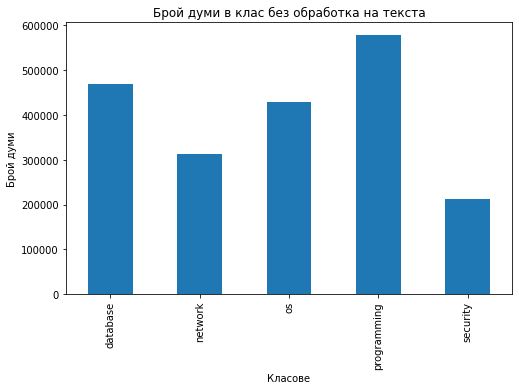

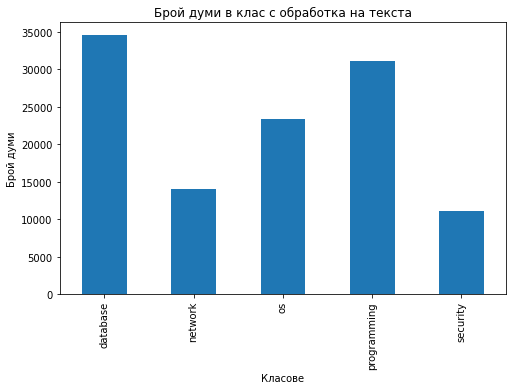

In [116]:
plot_word_count('word_count_non_preprocessed','Брой думи в клас без обработка на текста')
plot_word_count('word_count_preprocessed','Брой думи в клас с обработка на текста')

Разпределение на примерите по класове

Text(0.5, 0, 'Класове')

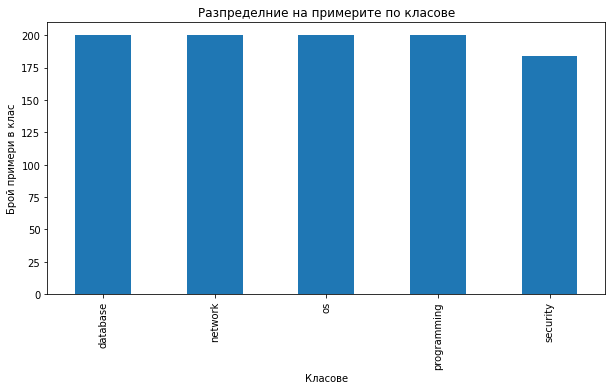

In [117]:
plt.figure(figsize=(10,5))
plt.title('Разпределние на примерите по класове')
df.groupby('target').content.apply(lambda x : len(x)).plot.bar()
plt.ylabel('Брой примери в клас')
plt.xlabel("Класове")

Превръщане на номиналните стойности в числа

In [61]:
df['target_numeric'] = pd.factorize(df['target'])[0]

class_id_df = df[['target','target_numeric']].drop_duplicates()

class_to_id = dict(class_id_df.values)
id_to_class= dict(df[['target_numeric','target']].values)
labels = df['target_numeric']
class_names = df.target.unique()
print(f"Класове - '{', '.join(class_names)}'")
print(class_to_id)
print(id_to_class)

Класове - 'network, os, programming, security, database'
{'network': 0, 'os': 1, 'programming': 2, 'security': 3, 'database': 4}
{0: 'network', 1: 'os', 2: 'programming', 3: 'security', 4: 'database'}


При разделянето на данните, 80% се използват за трениране, 20% за крайната оценка на моделите.

In [62]:
X_train,X_test, y_train, y_test = train_test_split(df['all_text_columns'], 
                                                   labels,
                                                   random_state=1,
                                                   stratify=labels,
                                                   test_size=0.2,
                                                   shuffle=True)

In [63]:
print("Трениращо множество " +str(X_train.shape))
print("Тестващо множество " + str(X_test.shape))

Трениращо множество (787,)
Тестващо множество (197,)


In [64]:
tf = TfidfVectorizer(ngram_range=(1,2),tokenizer=tokenizer)
features = tf.fit_transform(X_train)


In [65]:
print(f"Брой атрибути {len(tf.get_feature_names())}")

Брой атрибути 55106


За всеки клас се визуализира Word cloud от 10-те
най-важни думи за всеки клас. За да се изчисли дали дадена дума е значима за класа се използва $\chi^2$ статистика

In [66]:
# selecter = SelectKBest(score_func=chi2,k=12)
# selecter.fit_transform(features,y_train)
# selecter.get_feature_names_out()

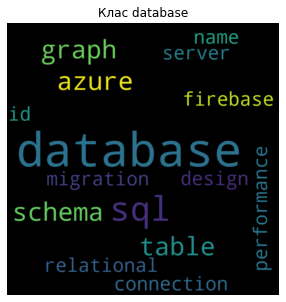

		database
unigrams: migration, databases, azure, table, graph, firebase, schema, sql, id, database
bigrams: database connection, table name, relational database, sql server, azure sql, database schema, sql database, database performance, database design, graph databases


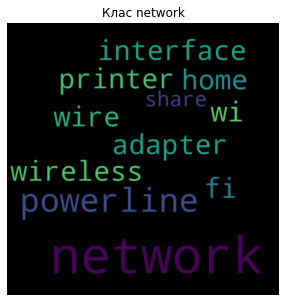

		network
unigrams: home, adapter, interface, wire, wi, fi, printer, wireless, powerline, network
bigrams: network powerline, network adapter, network share, wire network, wi fi, network interface, network printer, home network, wireless network, powerline network


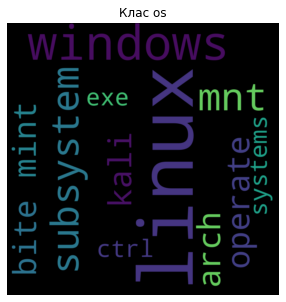

		os
unigrams: ctrl, windows, operate, exe, subsystem, arch, mint, mnt, kali, linux
bigrams: linux windows, mnt mnt, bite bite, operate systems, subsystem linux, windows subsystem, windows windows, arch linux, linux mint, kali linux


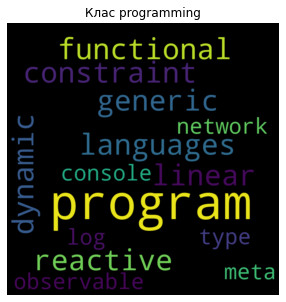

		programming
unigrams: observable, dynamic, languages, type, reactive, functional, generic, linear, constraint, program
bigrams: dynamic program, network program, meta program, program languages, console log, reactive program, functional program, linear program, constraint program, generic program


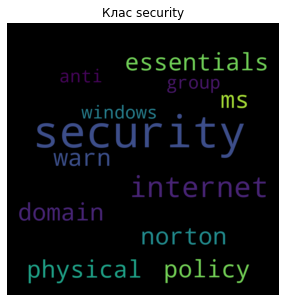

		security
unigrams: anti, ms, policy, physical, warn, essentials, norton, domain, internet, security
bigrams: windows security, security group, security policy, norton internet, ms security, domain security, physical security, security essentials, security warn, internet security


In [120]:
N = 10
for cls,cls_id in sorted(class_to_id.items()):
    features_chi2 = chi2(features,y_train == cls_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tf.get_feature_names_out())[indices]
    unigram =[v for v in feature_names  if len(v.split(" ")) ==1]
    bigram = [v for v in feature_names if len(v.split(" ")) == 2]
    grams = [word for word in feature_names if len(word.split(" ")) in [1,2]]
    
    show_wordcloud(" ".join([*unigram[-N:],*bigram[-N:]]),cls)
    print("\t\t%s" %(cls))
    print("unigrams: %s" % ", ".join(unigram[-N:]))
    print("bigrams: %s" % ", ".join(bigram[-N:]))
    

#  Настройка на хиперпараметри на модели и обучаването им

In [82]:
# Хиперпараметри за Suppor Vector Machine

svc_hyperparams_grid = {
    'classifier__gamma':[0.001, 0.0001,0,1] ,
    'classifier__kernel':["linear", "rbf",],
    'classifier__C': [1, 10, 100, 1000]
}
 
# Хиперпараметри за Logistic Regression
lr_hyperparams_grid = {
    "classifier__C": [100 ,10, 1.0, 0.1, 0.01],
    "classifier__solver": ['newton-cg' , 'lbfgs', 'saga']
    
}

# Хиперпараметри за Multinomial Naive Bayes
nb_hyperparams_grid = {
    "classifier__alpha": [0] + list(np.linspace(0.01, 1.0,5)),  
}

In [83]:
baseline_grid = build_grid()
svc_grid = build_grid(svc_hyperparams_grid)
lr_grid = build_grid(lr_hyperparams_grid)
nb_grid = build_grid(nb_hyperparams_grid,dim_reduction=False)
lr_grid

{'vectorizer__ngram_range': [(1, 1), (1, 2)],
 'vectorizer__max_features': [1500, 1000, 900, None],
 'vectorizer__min_df': [1, 2],
 'feature_selection__k': [800, 900, 1000],
 'dim_reduction__n_components': [100, 200, 300, 400],
 'classifier__C': [100, 10, 1.0, 0.1, 0.01],
 'classifier__solver': ['newton-cg', 'lbfgs', 'saga']}

In [99]:
models = [
    [DummyClassifier(strategy="most_frequent"),baseline_grid],
    [MultinomialNB(), nb_grid],
    [SVC(),svc_grid],
    [LogisticRegression(multi_class="multinomial"),lr_grid]
]

CV=10
pipelines = []
for pair in models:
    print(str(pair[0]))
    model_pipeline = build_pipeline(pair[0])

    model_rcv = RandomizedSearchCV(model_pipeline, param_distributions=pair[1],cv=CV,verbose=8, n_iter=20)
    model_rcv.fit(X_train,y_train)
    pipelines.append((str(pair[0]), model_rcv))

# svc_pipeline = build_pipeline(svc)

DummyClassifier(strategy='most_frequent')
Fitting 10 folds for each of 20 candidates, totalling 200 fits
[CV 1/10] END dim_reduction__n_components=100, feature_selection__k=800, vectorizer__max_features=None, vectorizer__min_df=2, vectorizer__ngram_range=(1, 2);, score=0.203 total time=  10.9s
[CV 2/10] END dim_reduction__n_components=100, feature_selection__k=800, vectorizer__max_features=None, vectorizer__min_df=2, vectorizer__ngram_range=(1, 2);, score=0.203 total time=  10.6s
[CV 3/10] END dim_reduction__n_components=100, feature_selection__k=800, vectorizer__max_features=None, vectorizer__min_df=2, vectorizer__ngram_range=(1, 2);, score=0.203 total time=  10.6s
[CV 4/10] END dim_reduction__n_components=100, feature_selection__k=800, vectorizer__max_features=None, vectorizer__min_df=2, vectorizer__ngram_range=(1, 2);, score=0.203 total time=  10.7s
[CV 5/10] END dim_reduction__n_components=100, feature_selection__k=800, vectorizer__max_features=None, vectorizer__min_df=2, vectorize

[CV 4/10] END dim_reduction__n_components=400, feature_selection__k=900, vectorizer__max_features=None, vectorizer__min_df=2, vectorizer__ngram_range=(1, 1);, score=0.203 total time=  11.6s
[CV 5/10] END dim_reduction__n_components=400, feature_selection__k=900, vectorizer__max_features=None, vectorizer__min_df=2, vectorizer__ngram_range=(1, 1);, score=0.203 total time=  11.4s
[CV 6/10] END dim_reduction__n_components=400, feature_selection__k=900, vectorizer__max_features=None, vectorizer__min_df=2, vectorizer__ngram_range=(1, 1);, score=0.203 total time=  10.9s
[CV 7/10] END dim_reduction__n_components=400, feature_selection__k=900, vectorizer__max_features=None, vectorizer__min_df=2, vectorizer__ngram_range=(1, 1);, score=0.203 total time=  11.6s
[CV 8/10] END dim_reduction__n_components=400, feature_selection__k=900, vectorizer__max_features=None, vectorizer__min_df=2, vectorizer__ngram_range=(1, 1);, score=0.205 total time=  11.3s
[CV 9/10] END dim_reduction__n_components=400, fea

[CV 8/10] END dim_reduction__n_components=400, feature_selection__k=900, vectorizer__max_features=1500, vectorizer__min_df=1, vectorizer__ngram_range=(1, 2);, score=0.205 total time=  11.1s
[CV 9/10] END dim_reduction__n_components=400, feature_selection__k=900, vectorizer__max_features=1500, vectorizer__min_df=1, vectorizer__ngram_range=(1, 2);, score=0.205 total time=  11.4s
[CV 10/10] END dim_reduction__n_components=400, feature_selection__k=900, vectorizer__max_features=1500, vectorizer__min_df=1, vectorizer__ngram_range=(1, 2);, score=0.205 total time=  11.4s
[CV 1/10] END dim_reduction__n_components=100, feature_selection__k=900, vectorizer__max_features=1000, vectorizer__min_df=2, vectorizer__ngram_range=(1, 1);, score=0.203 total time=  11.0s
[CV 2/10] END dim_reduction__n_components=100, feature_selection__k=900, vectorizer__max_features=1000, vectorizer__min_df=2, vectorizer__ngram_range=(1, 1);, score=0.203 total time=  11.2s
[CV 3/10] END dim_reduction__n_components=100, fe

[CV 2/10] END dim_reduction__n_components=400, feature_selection__k=800, vectorizer__max_features=1500, vectorizer__min_df=2, vectorizer__ngram_range=(1, 1);, score=0.203 total time=  11.5s
[CV 3/10] END dim_reduction__n_components=400, feature_selection__k=800, vectorizer__max_features=1500, vectorizer__min_df=2, vectorizer__ngram_range=(1, 1);, score=0.203 total time=  11.4s
[CV 4/10] END dim_reduction__n_components=400, feature_selection__k=800, vectorizer__max_features=1500, vectorizer__min_df=2, vectorizer__ngram_range=(1, 1);, score=0.203 total time=  11.2s
[CV 5/10] END dim_reduction__n_components=400, feature_selection__k=800, vectorizer__max_features=1500, vectorizer__min_df=2, vectorizer__ngram_range=(1, 1);, score=0.203 total time=  11.2s
[CV 6/10] END dim_reduction__n_components=400, feature_selection__k=800, vectorizer__max_features=1500, vectorizer__min_df=2, vectorizer__ngram_range=(1, 1);, score=0.203 total time=  11.1s
[CV 7/10] END dim_reduction__n_components=400, fea

[CV 5/10] END dim_reduction__n_components=300, feature_selection__k=800, vectorizer__max_features=None, vectorizer__min_df=2, vectorizer__ngram_range=(1, 2);, score=0.203 total time=  11.2s
[CV 6/10] END dim_reduction__n_components=300, feature_selection__k=800, vectorizer__max_features=None, vectorizer__min_df=2, vectorizer__ngram_range=(1, 2);, score=0.203 total time=  11.3s
[CV 7/10] END dim_reduction__n_components=300, feature_selection__k=800, vectorizer__max_features=None, vectorizer__min_df=2, vectorizer__ngram_range=(1, 2);, score=0.203 total time=  11.4s
[CV 8/10] END dim_reduction__n_components=300, feature_selection__k=800, vectorizer__max_features=None, vectorizer__min_df=2, vectorizer__ngram_range=(1, 2);, score=0.205 total time=  11.4s
[CV 9/10] END dim_reduction__n_components=300, feature_selection__k=800, vectorizer__max_features=None, vectorizer__min_df=2, vectorizer__ngram_range=(1, 2);, score=0.205 total time=  11.4s
[CV 10/10] END dim_reduction__n_components=300, fe

[CV 9/10] END classifier__alpha=0.2575, feature_selection__k=800, vectorizer__max_features=None, vectorizer__min_df=1, vectorizer__ngram_range=(1, 1);, score=0.949 total time=  11.0s
[CV 10/10] END classifier__alpha=0.2575, feature_selection__k=800, vectorizer__max_features=None, vectorizer__min_df=1, vectorizer__ngram_range=(1, 1);, score=0.910 total time=  11.4s
[CV 1/10] END classifier__alpha=0.505, feature_selection__k=900, vectorizer__max_features=None, vectorizer__min_df=1, vectorizer__ngram_range=(1, 2);, score=0.924 total time=  11.0s
[CV 2/10] END classifier__alpha=0.505, feature_selection__k=900, vectorizer__max_features=None, vectorizer__min_df=1, vectorizer__ngram_range=(1, 2);, score=0.975 total time=  11.1s
[CV 3/10] END classifier__alpha=0.505, feature_selection__k=900, vectorizer__max_features=None, vectorizer__min_df=1, vectorizer__ngram_range=(1, 2);, score=0.924 total time=  11.2s
[CV 4/10] END classifier__alpha=0.505, feature_selection__k=900, vectorizer__max_featur

[CV 5/10] END classifier__alpha=0, feature_selection__k=800, vectorizer__max_features=None, vectorizer__min_df=2, vectorizer__ngram_range=(1, 1);, score=0.937 total time=  10.9s
[CV 6/10] END classifier__alpha=0, feature_selection__k=800, vectorizer__max_features=None, vectorizer__min_df=2, vectorizer__ngram_range=(1, 1);, score=0.873 total time=  10.9s
[CV 7/10] END classifier__alpha=0, feature_selection__k=800, vectorizer__max_features=None, vectorizer__min_df=2, vectorizer__ngram_range=(1, 1);, score=0.861 total time=  10.8s
[CV 8/10] END classifier__alpha=0, feature_selection__k=800, vectorizer__max_features=None, vectorizer__min_df=2, vectorizer__ngram_range=(1, 1);, score=0.897 total time=  10.8s
[CV 9/10] END classifier__alpha=0, feature_selection__k=800, vectorizer__max_features=None, vectorizer__min_df=2, vectorizer__ngram_range=(1, 1);, score=0.910 total time=  10.9s
[CV 10/10] END classifier__alpha=0, feature_selection__k=800, vectorizer__max_features=None, vectorizer__min_d

[CV 1/10] END classifier__alpha=0.01, feature_selection__k=800, vectorizer__max_features=None, vectorizer__min_df=1, vectorizer__ngram_range=(1, 2);, score=0.911 total time=  11.2s
[CV 2/10] END classifier__alpha=0.01, feature_selection__k=800, vectorizer__max_features=None, vectorizer__min_df=1, vectorizer__ngram_range=(1, 2);, score=0.975 total time=  11.0s
[CV 3/10] END classifier__alpha=0.01, feature_selection__k=800, vectorizer__max_features=None, vectorizer__min_df=1, vectorizer__ngram_range=(1, 2);, score=0.911 total time=  10.9s
[CV 4/10] END classifier__alpha=0.01, feature_selection__k=800, vectorizer__max_features=None, vectorizer__min_df=1, vectorizer__ngram_range=(1, 2);, score=0.975 total time=  10.8s
[CV 5/10] END classifier__alpha=0.01, feature_selection__k=800, vectorizer__max_features=None, vectorizer__min_df=1, vectorizer__ngram_range=(1, 2);, score=0.975 total time=  11.0s
[CV 6/10] END classifier__alpha=0.01, feature_selection__k=800, vectorizer__max_features=None, 

[CV 7/10] END classifier__alpha=1.0, feature_selection__k=1000, vectorizer__max_features=900, vectorizer__min_df=1, vectorizer__ngram_range=(1, 1);, score=nan total time=   9.6s
[CV 8/10] END classifier__alpha=1.0, feature_selection__k=1000, vectorizer__max_features=900, vectorizer__min_df=1, vectorizer__ngram_range=(1, 1);, score=nan total time=   9.7s
[CV 9/10] END classifier__alpha=1.0, feature_selection__k=1000, vectorizer__max_features=900, vectorizer__min_df=1, vectorizer__ngram_range=(1, 1);, score=nan total time=   9.6s
[CV 10/10] END classifier__alpha=1.0, feature_selection__k=1000, vectorizer__max_features=900, vectorizer__min_df=1, vectorizer__ngram_range=(1, 1);, score=nan total time=   9.8s
[CV 1/10] END classifier__alpha=0.2575, feature_selection__k=800, vectorizer__max_features=1500, vectorizer__min_df=1, vectorizer__ngram_range=(1, 2);, score=0.924 total time=  10.8s
[CV 2/10] END classifier__alpha=0.2575, feature_selection__k=800, vectorizer__max_features=1500, vectori

[CV 2/10] END classifier__C=100, classifier__gamma=0, classifier__kernel=linear, dim_reduction__n_components=200, feature_selection__k=900, vectorizer__max_features=900, vectorizer__min_df=1, vectorizer__ngram_range=(1, 1);, score=nan total time=  10.0s
[CV 3/10] END classifier__C=100, classifier__gamma=0, classifier__kernel=linear, dim_reduction__n_components=200, feature_selection__k=900, vectorizer__max_features=900, vectorizer__min_df=1, vectorizer__ngram_range=(1, 1);, score=nan total time=  10.3s
[CV 4/10] END classifier__C=100, classifier__gamma=0, classifier__kernel=linear, dim_reduction__n_components=200, feature_selection__k=900, vectorizer__max_features=900, vectorizer__min_df=1, vectorizer__ngram_range=(1, 1);, score=nan total time=   9.4s
[CV 5/10] END classifier__C=100, classifier__gamma=0, classifier__kernel=linear, dim_reduction__n_components=200, feature_selection__k=900, vectorizer__max_features=900, vectorizer__min_df=1, vectorizer__ngram_range=(1, 1);, score=nan tot

[CV 5/10] END classifier__C=1000, classifier__gamma=0, classifier__kernel=rbf, dim_reduction__n_components=300, feature_selection__k=800, vectorizer__max_features=1000, vectorizer__min_df=1, vectorizer__ngram_range=(1, 1);, score=nan total time=  10.6s
[CV 6/10] END classifier__C=1000, classifier__gamma=0, classifier__kernel=rbf, dim_reduction__n_components=300, feature_selection__k=800, vectorizer__max_features=1000, vectorizer__min_df=1, vectorizer__ngram_range=(1, 1);, score=nan total time=  10.5s
[CV 7/10] END classifier__C=1000, classifier__gamma=0, classifier__kernel=rbf, dim_reduction__n_components=300, feature_selection__k=800, vectorizer__max_features=1000, vectorizer__min_df=1, vectorizer__ngram_range=(1, 1);, score=nan total time=  10.5s
[CV 8/10] END classifier__C=1000, classifier__gamma=0, classifier__kernel=rbf, dim_reduction__n_components=300, feature_selection__k=800, vectorizer__max_features=1000, vectorizer__min_df=1, vectorizer__ngram_range=(1, 1);, score=nan total t

[CV 7/10] END classifier__C=100, classifier__gamma=0.001, classifier__kernel=rbf, dim_reduction__n_components=400, feature_selection__k=800, vectorizer__max_features=900, vectorizer__min_df=2, vectorizer__ngram_range=(1, 2);, score=0.949 total time=  11.6s
[CV 8/10] END classifier__C=100, classifier__gamma=0.001, classifier__kernel=rbf, dim_reduction__n_components=400, feature_selection__k=800, vectorizer__max_features=900, vectorizer__min_df=2, vectorizer__ngram_range=(1, 2);, score=0.936 total time=  11.9s
[CV 9/10] END classifier__C=100, classifier__gamma=0.001, classifier__kernel=rbf, dim_reduction__n_components=400, feature_selection__k=800, vectorizer__max_features=900, vectorizer__min_df=2, vectorizer__ngram_range=(1, 2);, score=0.987 total time=  12.3s
[CV 10/10] END classifier__C=100, classifier__gamma=0.001, classifier__kernel=rbf, dim_reduction__n_components=400, feature_selection__k=800, vectorizer__max_features=900, vectorizer__min_df=2, vectorizer__ngram_range=(1, 2);, sc

[CV 9/10] END classifier__C=10, classifier__gamma=0.001, classifier__kernel=rbf, dim_reduction__n_components=100, feature_selection__k=900, vectorizer__max_features=1000, vectorizer__min_df=2, vectorizer__ngram_range=(1, 2);, score=0.782 total time=  11.4s
[CV 10/10] END classifier__C=10, classifier__gamma=0.001, classifier__kernel=rbf, dim_reduction__n_components=100, feature_selection__k=900, vectorizer__max_features=1000, vectorizer__min_df=2, vectorizer__ngram_range=(1, 2);, score=0.782 total time=  11.5s
[CV 1/10] END classifier__C=1000, classifier__gamma=0.001, classifier__kernel=rbf, dim_reduction__n_components=200, feature_selection__k=1000, vectorizer__max_features=1500, vectorizer__min_df=2, vectorizer__ngram_range=(1, 1);, score=0.937 total time=  12.0s
[CV 2/10] END classifier__C=1000, classifier__gamma=0.001, classifier__kernel=rbf, dim_reduction__n_components=200, feature_selection__k=1000, vectorizer__max_features=1500, vectorizer__min_df=2, vectorizer__ngram_range=(1, 1

[CV 1/10] END classifier__C=1000, classifier__gamma=0, classifier__kernel=linear, dim_reduction__n_components=200, feature_selection__k=1000, vectorizer__max_features=1000, vectorizer__min_df=2, vectorizer__ngram_range=(1, 1);, score=nan total time=  10.4s
[CV 2/10] END classifier__C=1000, classifier__gamma=0, classifier__kernel=linear, dim_reduction__n_components=200, feature_selection__k=1000, vectorizer__max_features=1000, vectorizer__min_df=2, vectorizer__ngram_range=(1, 1);, score=nan total time=  10.3s
[CV 3/10] END classifier__C=1000, classifier__gamma=0, classifier__kernel=linear, dim_reduction__n_components=200, feature_selection__k=1000, vectorizer__max_features=1000, vectorizer__min_df=2, vectorizer__ngram_range=(1, 1);, score=nan total time=  10.3s
[CV 4/10] END classifier__C=1000, classifier__gamma=0, classifier__kernel=linear, dim_reduction__n_components=200, feature_selection__k=1000, vectorizer__max_features=1000, vectorizer__min_df=2, vectorizer__ngram_range=(1, 1);, s

[CV 4/10] END classifier__C=10, classifier__gamma=0, classifier__kernel=linear, dim_reduction__n_components=400, feature_selection__k=900, vectorizer__max_features=None, vectorizer__min_df=1, vectorizer__ngram_range=(1, 2);, score=nan total time=  10.2s
[CV 5/10] END classifier__C=10, classifier__gamma=0, classifier__kernel=linear, dim_reduction__n_components=400, feature_selection__k=900, vectorizer__max_features=None, vectorizer__min_df=1, vectorizer__ngram_range=(1, 2);, score=nan total time=  10.9s
[CV 6/10] END classifier__C=10, classifier__gamma=0, classifier__kernel=linear, dim_reduction__n_components=400, feature_selection__k=900, vectorizer__max_features=None, vectorizer__min_df=1, vectorizer__ngram_range=(1, 2);, score=nan total time=  10.6s
[CV 7/10] END classifier__C=10, classifier__gamma=0, classifier__kernel=linear, dim_reduction__n_components=400, feature_selection__k=900, vectorizer__max_features=None, vectorizer__min_df=1, vectorizer__ngram_range=(1, 2);, score=nan tot

[CV 7/10] END classifier__C=100, classifier__gamma=0, classifier__kernel=linear, dim_reduction__n_components=100, feature_selection__k=800, vectorizer__max_features=1000, vectorizer__min_df=2, vectorizer__ngram_range=(1, 2);, score=nan total time=  10.4s
[CV 8/10] END classifier__C=100, classifier__gamma=0, classifier__kernel=linear, dim_reduction__n_components=100, feature_selection__k=800, vectorizer__max_features=1000, vectorizer__min_df=2, vectorizer__ngram_range=(1, 2);, score=nan total time=  10.5s
[CV 9/10] END classifier__C=100, classifier__gamma=0, classifier__kernel=linear, dim_reduction__n_components=100, feature_selection__k=800, vectorizer__max_features=1000, vectorizer__min_df=2, vectorizer__ngram_range=(1, 2);, score=nan total time=  10.3s
[CV 10/10] END classifier__C=100, classifier__gamma=0, classifier__kernel=linear, dim_reduction__n_components=100, feature_selection__k=800, vectorizer__max_features=1000, vectorizer__min_df=2, vectorizer__ngram_range=(1, 2);, score=na

[CV 2/10] END classifier__C=10, classifier__solver=newton-cg, dim_reduction__n_components=400, feature_selection__k=1000, vectorizer__max_features=900, vectorizer__min_df=1, vectorizer__ngram_range=(1, 2);, score=nan total time=  10.4s
[CV 3/10] END classifier__C=10, classifier__solver=newton-cg, dim_reduction__n_components=400, feature_selection__k=1000, vectorizer__max_features=900, vectorizer__min_df=1, vectorizer__ngram_range=(1, 2);, score=nan total time=  10.5s
[CV 4/10] END classifier__C=10, classifier__solver=newton-cg, dim_reduction__n_components=400, feature_selection__k=1000, vectorizer__max_features=900, vectorizer__min_df=1, vectorizer__ngram_range=(1, 2);, score=nan total time=  10.2s
[CV 5/10] END classifier__C=10, classifier__solver=newton-cg, dim_reduction__n_components=400, feature_selection__k=1000, vectorizer__max_features=900, vectorizer__min_df=1, vectorizer__ngram_range=(1, 2);, score=nan total time=  10.1s
[CV 6/10] END classifier__C=10, classifier__solver=newto

[CV 7/10] END classifier__C=10, classifier__solver=lbfgs, dim_reduction__n_components=300, feature_selection__k=800, vectorizer__max_features=900, vectorizer__min_df=2, vectorizer__ngram_range=(1, 1);, score=0.899 total time=  11.3s
[CV 8/10] END classifier__C=10, classifier__solver=lbfgs, dim_reduction__n_components=300, feature_selection__k=800, vectorizer__max_features=900, vectorizer__min_df=2, vectorizer__ngram_range=(1, 1);, score=0.923 total time=  11.6s
[CV 9/10] END classifier__C=10, classifier__solver=lbfgs, dim_reduction__n_components=300, feature_selection__k=800, vectorizer__max_features=900, vectorizer__min_df=2, vectorizer__ngram_range=(1, 1);, score=0.962 total time=  11.5s
[CV 10/10] END classifier__C=10, classifier__solver=lbfgs, dim_reduction__n_components=300, feature_selection__k=800, vectorizer__max_features=900, vectorizer__min_df=2, vectorizer__ngram_range=(1, 1);, score=0.923 total time=  11.5s
[CV 1/10] END classifier__C=10, classifier__solver=lbfgs, dim_reduc

[CV 2/10] END classifier__C=0.1, classifier__solver=lbfgs, dim_reduction__n_components=200, feature_selection__k=800, vectorizer__max_features=None, vectorizer__min_df=2, vectorizer__ngram_range=(1, 2);, score=0.949 total time=  11.8s
[CV 3/10] END classifier__C=0.1, classifier__solver=lbfgs, dim_reduction__n_components=200, feature_selection__k=800, vectorizer__max_features=None, vectorizer__min_df=2, vectorizer__ngram_range=(1, 2);, score=0.886 total time=  11.3s
[CV 4/10] END classifier__C=0.1, classifier__solver=lbfgs, dim_reduction__n_components=200, feature_selection__k=800, vectorizer__max_features=None, vectorizer__min_df=2, vectorizer__ngram_range=(1, 2);, score=0.987 total time=  11.4s
[CV 5/10] END classifier__C=0.1, classifier__solver=lbfgs, dim_reduction__n_components=200, feature_selection__k=800, vectorizer__max_features=None, vectorizer__min_df=2, vectorizer__ngram_range=(1, 2);, score=0.975 total time=  11.5s
[CV 6/10] END classifier__C=0.1, classifier__solver=lbfgs, d

[CV 7/10] END classifier__C=100, classifier__solver=saga, dim_reduction__n_components=400, feature_selection__k=1000, vectorizer__max_features=900, vectorizer__min_df=1, vectorizer__ngram_range=(1, 2);, score=nan total time=  12.3s
[CV 8/10] END classifier__C=100, classifier__solver=saga, dim_reduction__n_components=400, feature_selection__k=1000, vectorizer__max_features=900, vectorizer__min_df=1, vectorizer__ngram_range=(1, 2);, score=nan total time=  11.0s
[CV 9/10] END classifier__C=100, classifier__solver=saga, dim_reduction__n_components=400, feature_selection__k=1000, vectorizer__max_features=900, vectorizer__min_df=1, vectorizer__ngram_range=(1, 2);, score=nan total time=  10.7s
[CV 10/10] END classifier__C=100, classifier__solver=saga, dim_reduction__n_components=400, feature_selection__k=1000, vectorizer__max_features=900, vectorizer__min_df=1, vectorizer__ngram_range=(1, 2);, score=nan total time=   9.9s
[CV 1/10] END classifier__C=100, classifier__solver=newton-cg, dim_redu

[CV 2/10] END classifier__C=100, classifier__solver=saga, dim_reduction__n_components=100, feature_selection__k=1000, vectorizer__max_features=None, vectorizer__min_df=1, vectorizer__ngram_range=(1, 1);, score=0.962 total time=  11.4s
[CV 3/10] END classifier__C=100, classifier__solver=saga, dim_reduction__n_components=100, feature_selection__k=1000, vectorizer__max_features=None, vectorizer__min_df=1, vectorizer__ngram_range=(1, 1);, score=0.886 total time=  11.5s
[CV 4/10] END classifier__C=100, classifier__solver=saga, dim_reduction__n_components=100, feature_selection__k=1000, vectorizer__max_features=None, vectorizer__min_df=1, vectorizer__ngram_range=(1, 1);, score=0.962 total time=  11.6s
[CV 5/10] END classifier__C=100, classifier__solver=saga, dim_reduction__n_components=100, feature_selection__k=1000, vectorizer__max_features=None, vectorizer__min_df=1, vectorizer__ngram_range=(1, 1);, score=0.987 total time=  11.8s
[CV 6/10] END classifier__C=100, classifier__solver=saga, di

# Резултати

In [108]:
final_clfs = []
for pipe in pipelines:
    model = pipe[1].best_estimator_    
    model.fit(X_train,y_train)
    final_clfs.append(model)
    preds = model.predict(X_test)
    model_scores = clf_scores(model[-1],y_test,preds,class_names)
    add_to_dict(model_scores)

				DummyClassifier
              precision    recall  f1-score   support

     network       0.20      1.00      0.34        40
          os       0.00      0.00      0.00        40
 programming       0.00      0.00      0.00        40
    security       0.00      0.00      0.00        37
    database       0.00      0.00      0.00        40

    accuracy                           0.20       197
   macro avg       0.04      0.20      0.07       197
weighted avg       0.04      0.20      0.07       197

				MultinomialNB
              precision    recall  f1-score   support

     network       0.95      0.93      0.94        40
          os       0.91      1.00      0.95        40
 programming       0.97      0.93      0.95        40
    security       1.00      0.97      0.99        37
    database       1.00      1.00      1.00        40

    accuracy                           0.96       197
   macro avg       0.97      0.96      0.96       197
weighted avg       0.97      0.96      

In [110]:
models_df = pd.DataFrame(final_models,index=final_models['names'])
models_df.drop(['names'],axis=1)

,Accuracy,Macro-Precision,Macro-Recall,Macro-F1
DummyClassifier,0.20,0.04,0.04,0.20
MultinomialNB,0.96,0.97,0.97,0.96
SVC,0.96,0.96,0.96,0.96
LogisticRegression,0.96,0.96,0.96,0.96


In [111]:
for pipeline in pipelines:
    print(f"Model: {pipeline[0][:-2]},\n\t Best score: {pipeline[1].best_score_},\n\t Best params {str(pipeline[1].best_params_)}")


Model: DummyClassifier(strategy='most_frequent,
	 Best score: 0.20331061343719573,
	 Best params {'vectorizer__ngram_range': (1, 2), 'vectorizer__min_df': 2, 'vectorizer__max_features': None, 'feature_selection__k': 800, 'dim_reduction__n_components': 100}
Model: MultinomialNB,
	 Best score: 0.9466244725738397,
	 Best params {'vectorizer__ngram_range': (1, 2), 'vectorizer__min_df': 1, 'vectorizer__max_features': None, 'feature_selection__k': 900, 'classifier__alpha': 0.505}
Model: SVC,
	 Best score: 0.9491723466407012,
	 Best params {'vectorizer__ngram_range': (1, 1), 'vectorizer__min_df': 2, 'vectorizer__max_features': 1500, 'feature_selection__k': 1000, 'dim_reduction__n_components': 200, 'classifier__kernel': 'rbf', 'classifier__gamma': 0.001, 'classifier__C': 1000}
Model: LogisticRegression(multi_class='multinomial,
	 Best score: 0.9504868549172347,
	 Best params {'vectorizer__ngram_range': (1, 2), 'vectorizer__min_df': 1, 'vectorizer__max_features': None, 'feature_selection__k': 9

Изпробване върху примери

In [112]:
os = """
We covered the Network Time Protocol Daemon a little in the article ‘https://www.linux.org/threads/lfcs-–-kerberos-authentication-centos7.39296/’, as well as in ‘https://www.linux.org/threads/lfcs-–-kerberos-authentication-ubuntu.39733/’.

This article will go a little deeper and add in another Network Time Protocol other than NTP.


Different Times

Each system has different times. I’m not referring to each being a different time than others.

Each system, especially Linux, has three different times:

    Real-Time Clock (RTC)
    Local Time
    Universal Time

The Real-Time Clock (RTC) is the time on the system that is controlled by an Integrated Circuit (IC) that keeps time. We see the RTC value on the BIOS screen showing date and time. The true value of the RTC doesn’t include any adjustments for the Time Zone.

Looking at the Local Time, it is the adjusted time of the RTC that takes into consideration the Time Zone.

Coordinated Universal Time (UTC) is the successor to the Greenwich Mean Time (GMT). This is the mean time by which we adjust the time by the Time Zone to get the real local time.

Basically, NTP will adjust the UTC, which will then adjust the RTC on the system board. Once corrected, then the Local time will be changed according to the Time Zone settings. For example, in Figure 1 for CentOS, you can see the Time Zone is ‘America/Indiana/Indianapolis (EDT, -0400)’. The system reduces the RTC time (5:19 A.M.) by four hours (Time Zone adjustment), resulting in the local time being 1:19 A.M.

Figure 1.jpg

FIGURE 1

Figure 2 shows the output for the same command on an Ubuntu system.

Figure 2.jpg

FIGURE 2

To change your date and time manually from a terminal, you can use the command ‘date --set “yyyymmdd hh:ss”’.

Network Time Protocol (NTP)

The system manages the Network Time Protocol (NTP) with the Network Time Protocol Daemon (NTPD).

For an easy way to determine if a system is using some type of time synchronization with a Time Server, is to run the command ‘timedatectl’. One line, on CentOS, in the output lists the status of ‘NTP Enabled’ and ‘NTP Synchronized’. The result is ‘yes’ or ‘no’. A system by default should not have NTP installed or enabled.

For Ubuntu, the line is ‘System Clock Synchronized: ’. By default, it is ‘no’.

On either system, you can check the service with the command ‘sudo systemctl status ntpd’. The result should be that the service is not found or inactive.

To install the Network Time Protocol Daemon, use ‘sudo yum install ntp -y’ for CentOS and ‘sudo apt install ntp -y’ for Ubuntu.

Once installed, you need to start the service, then enable it to start on system boot. A third command can check the status. Use the following commands for CentOS:

sudo systemctl start ntpd
sudo systemctl enable ntpd
sudo systemctl status ntpd

For Ubuntu, the commands are the same, except the service name:

sudo systemctl start ntp
sudo systemctl enable ntp
sudo systemctl status ntp

On either Operating System, you can check the configuration file located at ‘/etc/ntp.conf’. About halfway down the file should be lines similar to:

pool 0.ubuntu.pool.ntp.org iburst
pool 1.ubuntu.pool.ntp.org iburst
pool 2.ubuntu.pool.ntp.org iburst
pool 3.ubuntu.pool.ntp.org iburst

For CentOS, instead of ‘pool’ it says ‘server’. The server's name does not contain ‘ubuntu’, but ‘centos’. These are the servers that are used to sync the time from the Internet when enabling NTP.

The NTP service runs on UDP Port 123. You may need to open the firewall port if you have issues with time synchronization.

Once you have the NTP Service running, you can see which server you are using as the NTP Server by using the command ‘nptq -p’. It shows a list of servers that begin with the default pool from the configuration file. The server with the asterisk (*) next to it is the one your system is using.

You should notice a column that is listed as ‘poll’. The value should start out at 64 (seconds). The service checks the servers every 64 seconds for an update to the time. After time passes and the service determines that the time is not being updated, the polling time will increase by 64 seconds until it reaches 1024 (seconds).

Another important column is the Stratum (st) column. The time servers at the highest point are atomic clocks, GPS clock, etc. These are Stratum 0 since the time is originating with them. A system that gets its time from these servers will become a Stratum 1 time system. As each system goes down the line, it adds one to the stratum number. The higher a number, maximum of 15, the more probable that the time is off from the original time server.

To stop the Network Time Protocol Service, use the commands as follows: (using ‘ntp’ for Ubuntu and ‘ntpd’ for CentOS)

sudo systemctl disable <service>
sudo systemctl stop <service>

The NTP service is good for systems that are not rebooted often, such as servers. For another option of a time service, try Chrony.

Chrony

Chrony is a replacement for the Network Time Protocol Daemon (NTPD). The Chrony service works faster and better on systems that are rebooted often, such as desktops.

To install Chrony, use the command for CentOS:

sudo yum install chrony -y

For Ubuntu, use the following:

sudo apt install chrony -y

To start and enable the service on Ubuntu, use the following commands:

sudo systemctl start chrony
sudo systemctl enable chrony

For CentOS, use:

sudo systemctl start chronyd
sudo systemctl enable chronyd

The Chrony configuration file is found at ‘/etc/chrony.conf’ for CentOS and ‘/etc/chrony/chrony.conf’ for Ubuntu.

The files should look very similar to the configuration file for NTP.

To see the basic information about the time service, use the command ‘chronyc tracking’.

If you want to see the actual servers you are pooling from and which system is the one currently being used, use the command ‘chronyc sources’. The asterisk (*) is the current server being used to sync time.

Troubleshooting

The main two points to check on when you have problems is that the service is started. The second is that DNS resolution is occurring.

If you recall from the configuration files, the time servers are listed by name and not IP Address. If Domain Name resolution is not working, then the time synchronization cannot occur.

If DNS Resolution is not happening, get that working. Restart the NTP or Chrony service and then retry the synchronization.

Conclusion

Getting all systems on the same time can be a very beneficial tool on a network. In this manner, all log files are synchronized by time on all systems. Having the times synced can help troubleshoot issues between systems.

If some systems are off by a minute or more, there can be file sharing issues, etc.

On some networks, it may be best to have one or two time servers. The desktop clients can update from these two by changing the server name in the configuration file. If we sync the local time servers from the Internet, and we then sync all desktops from these two systems, then the local network times should be synced perfectly for the administrator."""

In [113]:
security="""
What is encryption?

Encryption is a way of scrambling data so that only authorized parties can understand the information. In technical terms, it is the process of converting human-readable plaintext to incomprehensible text, also known as ciphertext. In simpler terms, encryption takes readable data and alters it so that it appears random. Encryption requires the use of a cryptographic key: a set of mathematical values that both the sender and the recipient of an encrypted message agree on.
encryption example

Although encrypted data appears random, encryption proceeds in a logical, predictable way, allowing a party that receives the encrypted data and possesses the right key to decrypt the data, turning it back into plaintext. Truly secure encryption will use keys complex enough that a third party is highly unlikely to decrypt or break the ciphertext by brute force — in other words, by guessing the key.

Data can be encrypted "at rest," when it is stored, or "in transit," while it is being transmitted somewhere else.
What is a key in cryptography?

A cryptographic key is a string of characters used within an encryption algorithm for altering data so that it appears random. Like a physical key, it locks (encrypts) data so that only someone with the right key can unlock (decrypt) it.
What are the different types of encryption?

The two main kinds of encryption are symmetric encryption and asymmetric encryption. Asymmetric encryption is also known as public key encryption.

In symmetric encryption, there is only one key, and all communicating parties use the same (secret) key for both encryption and decryption. In asymmetric, or public key, encryption, there are two keys: one key is used for encryption, and a different key is used for decryption. The decryption key is kept private (hence the "private key" name), while the encryption key is shared publicly, for anyone to use (hence the "public key" name). Asymmetric encryption is a foundational technology for TLS (often called SSL).
Why is data encryption necessary?

Privacy: Encryption ensures that no one can read communications or data at rest except the intended recipient or the rightful data owner. This prevents attackers, ad networks, Internet service providers, and in some cases governments from intercepting and reading sensitive data.

Security: Encryption helps prevent data breaches, whether the data is in transit or at rest. If a corporate device is lost or stolen and its hard drive is properly encrypted, the data on that device will still be secure. Similarly, encrypted communications enable the communicating parties to exchange sensitive data without leaking the data.

Data integrity: Encryption also helps prevent malicious behavior such as on-path attacks. When data is transmitted across the Internet, encryption (along with other integrity protections) ensures that what the recipient receives has not been tampered with on the way.

Authentication: Public key encryption, among other things, can be used to establish that a website's owner owns the private key listed in the website's TLS certificate. This allows users of the website to be sure that they are connected to the real website (see What is public key encryption? to learn more).

Regulations: For all these reasons, many industry and government regulations require companies that handle user data to keep that data encrypted. Examples of regulatory and compliance standards that require encryption include HIPAA, PCI-DSS, and the GDPR.
What is an encryption algorithm?

An encryption algorithm is the method used to transform data into ciphertext. An algorithm will use the encryption key in order to alter the data in a predictable way, so that even though the encrypted data will appear random, it can be turned back into plaintext by using the decryption key.
What are some common encryption algorithms?

Commonly used symmetric encryption algorithms include:

    AES
    3-DES
    SNOW

Commonly used asymmetric encryption algorithms include:

    RSA
    Elliptic curve cryptography

What is a brute force attack in encryption?

A brute force attack is when an attacker who does not know the decryption key attempts to determine the key by making millions or billions of guesses. Brute force attacks are much faster with modern computers, which is why encryption has to be extremely strong and complex. Most modern encryption methods, coupled with high-quality passwords, are resistant to brute force attacks, although they may become vulnerable to such attacks in the future as computers become more and more powerful. Weak passwords are still susceptible to brute force attacks.
How is encryption used to keep Internet browsing secure?

Encryption is foundational for a variety of technologies, but it is especially important for keeping HTTP requests and responses secure, and for authenticating website origin servers. The protocol responsible for this is called HTTPS (Hypertext Transfer Protocol Secure). A website served over HTTPS instead of HTTP will have a URL that begins with https:// instead of http://, usually represented by a secured lock in the address bar.

HTTPS uses the encryption protocol called Transport Layer Security (TLS). In the past, an earlier encryption protocol called Secure Sockets Layer (SSL) was the standard, but TLS has replaced SSL. A website that implements HTTPS will have a TLS certificate installed on its origin server. Learn more about TLS and HTTPS.

To help keep the Internet more secure, Cloudflare offers free TLS/SSL encryption for any websites using Cloudflare services. Learn more about Universal SSL from Cloudflare."""

In [114]:
examples  ={
    "os": os,
    "security": security
}

Изпробване на моделите върху примери

In [115]:
print("\tReal\tPredicted")
print("_"*40)

for pred in final_clfs:
    model_name = str(pred[-1])
    model_name = model_name[0: model_name.index('(')]                
    print(str(model_name))
    for example in examples.items():
       
        predict = pred.predict([example[1]])
        print("\t" + example[0] + " - " + id_to_class[predict[0]])


	Real	Predicted
________________________________________
DummyClassifier
	os - network
	security - network
MultinomialNB
	os - os
	security - network
SVC
	os - os
	security - security
LogisticRegression
	os - os
	security - programming
